In [1]:
!pip install xlrd
!pip install adversarial-robustness-toolbox
!pip install opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.17.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 4.9 MB/s eta 0:00:00


In [2]:
import sys
import os
import pandas as pd
import numpy as np # for array operations
import requests, io # for HTTP requests and I/O commands
import matplotlib.pyplot as plt # for data visualization
from google.colab import drive
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification.pytorch import PyTorchClassifier
from opacus import PrivacyEngine
from tqdm import tqdm
import itertools
from sklearn.model_selection import StratifiedKFold

drive.mount('/content/drive', force_remount=True)
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/'
#dataset = pd.read_excel(r"/content/drive/MyDrive/Colab Notebooks/default_of_credit_card_clients.xlsx")
dataset = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/creditcard.csv")
#print(dataset)

Mounted at /content/drive


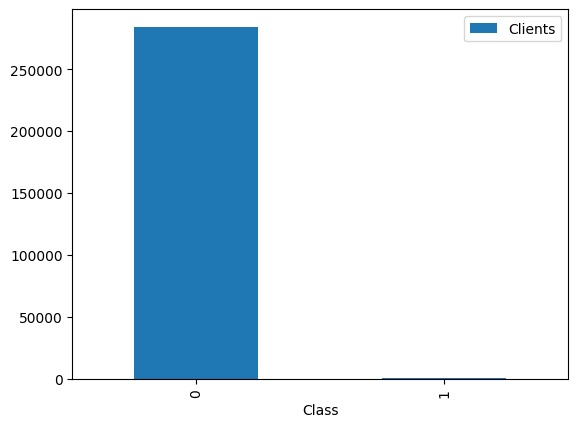

In [3]:
#print(len(dataset.query("default_payment_next_month ==0")))
#print(len(dataset.query("default_payment_next_month ==1")))

data = {
  "Class": [0,1],
  "Clients": [len(dataset.query("Class == 0")),
              len(dataset.query("Class == 1"))]
}

#load data into a DataFrame object:
df = pd.DataFrame(data)

df.plot(kind = 'bar', x='Class',y = 'Clients')
plt.show()

In [4]:
X = dataset.drop(['Class'],axis=1)[1:50000]
y = dataset.Class[1:50000]
y.shape

(49999,)

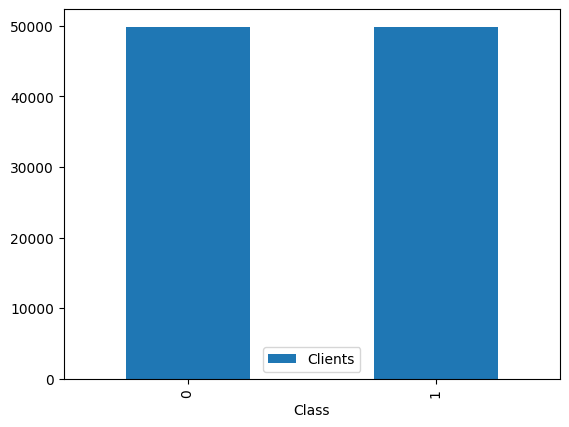

In [5]:
smt = SMOTE()
X_sm, y_sm = smt.fit_resample(X,y)
df_sm = pd.concat([X_sm, y_sm], axis=1, join='inner')
data = {
  "Class": [0,1],
  "Clients": [len(df_sm.query("Class ==0")),
              len(df_sm.query("Class ==1"))]
}

#load data into a DataFrame object:
df_p = pd.DataFrame(data)

df_p.plot(kind = 'bar', x='Class',y = 'Clients')
plt.show()

In [6]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32)).reshape(-1, 1)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len




In [7]:
class FraudClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(29, 128)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.hidden2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.hidden3 = nn.Linear(64, 16)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(16, 8)
        self.act4 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.dropout1(x)
        x = self.act2(self.hidden2(x))
        x = self.dropout2(x)
        x = self.act3(self.hidden3(x))
        x = self.dropout3(x)
        x = self.act4(self.hidden4(x))
        x = self.act_output(self.output(x))
        return x



In [8]:
def accuracy(preds, labels):
    return (preds == labels).mean()

def evaluate(model, test_dataloader):
    model.eval()
    loss_arr = []
    accuracy_arr = []
    for (data, target) in test_dataloader:
      y_pred = model(data)
      acc = (y_pred.round() == target).float().mean()
      acc = float(acc)
      accuracy_arr.append(acc)
    return np.mean(accuracy_arr)

In [9]:
def model_train(model, train_dataloader, test_dataloader, n_epochs=5):
    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
    model.train()
    for epoch in range(n_epochs):
      for (data, target) in train_dataloader:
            y_pred = model(data)
            loss = loss_fn(y_pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    accuracies=[]
    model.eval()
    for (data, target) in test_dataloader:
      y_pred = model(data)
      acc = (y_pred.round() == target).float().mean()
      acc = float(acc)
      accuracies.append(acc)
    mean = np.mean(accuracies)
    std = np.std(accuracies)
    #print("Baseline: %.2f%% (+/- %.2f%%)" % (mean*100, std*100))
    return mean,std

#for i in range(1,2):
#    accuracies = model_train(model)

# evaluate the model
#mean = np.mean(accuracies)
#std = np.std(accuracies)
#print("Baseline: %.2f%% (+/- %.2f%%)" % (mean*100, std*100))

In [10]:
def train(model, train_dataloader, optimizer, epochs, delta, privacy_engine):
    loss_fn = torch.nn.BCELoss()
    model.train()
    loss_values = []
    total = 0
    correct = 0
    print(correct)
    for epoch in range(epochs):
      for (data, target) in train_dataloader:
        y_pred = model(data)
        loss = loss_fn(y_pred, target)
        print(loss)
        loss_values.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #epsilon = privacy_engine.get_epsilon(delta)
    #print(
    #    f"Train Epoch: {epoch} \t"
    #    f"Loss: {np.mean(loss_values):.6f} "
    #    f"(ε = {epsilon:.2f}, δ = {delta})")
    return model
#for epoch in range(1, 10):
#  train_dataloader, test_dataloader,X_train, X_test, y_train, y_test = _splitData(df_sm)
#  train(model, train_dataloader, optimizer, epoch, device="cpu", delta=1e-5)


In [11]:
def test(model, test_dataloader, privacy_engine, delta):
    acc = evaluate(model, test_dataloader)
    #print(acc)
    #printstr = "\n----------------------------\n" f"Test Accuracy: {acc}"
    if privacy_engine:
        epsilon = privacy_engine.get_epsilon(delta)
        #printstr += f" (ε = {epsilon:.2f}, δ = {delta})"
    #print(printstr + "\n----------------------------\n")
    return acc, epsilon, delta
#for epoch in range(1, 2):
    #test(model, test_dataloader, privacy_engine, device)

In [ ]:
#mlp_art_model = PyTorchClassifier(model=model, loss=loss_fn, optimizer=optimizer, input_shape=(29,), nb_classes=2)

#train_pred = mlp_art_model.predict(X_train.astype(np.float32))
#acc = (train_pred.round() == y_train).mean()
#acc = float(acc)
#print('Base model Train accuracy: ', acc)

#test_pred = mlp_art_model.predict(X_test.astype(np.float32))
#acc = (train_pred.round() == y_test).mean()
#acc = float(acc)
#print('Base model Test accuracy: ', acc)

In [ ]:
#mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')

#mlp_attack_bb.fit(X_train.astype(np.float32),y_train.astype(np.float32),X_test.astype(np.float32), y_test.astype(np.float32))

#mlp_inferred_train_bb = mlp_attack_bb.infer(X_train.astype(np.float32), y_train)
#mlp_inferred_test_bb = mlp_attack_bb.infer(X_test.astype(np.float32), y_test)

#mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
#mlp_test_acc_bb = 1-(np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
#mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))

#print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
#print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
#print(f"Attack Accuracy {mlp_acc_bb:.4f}")


In [ ]:
#from sklearn.metrics import classification_report

#y_train_pred = np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb))
#y_train_true = np.concatenate((np.ones_like(mlp_inferred_train_bb), np.zeros_like(mlp_inferred_test_bb)))
#print(classification_report(y_pred=y_train_pred, y_true=y_train_true))

In [12]:
def _splitData(df_sm):
  batch_size = 128
  X_o = df_sm.drop(['Time','Class'],axis=1)
  y_o = df_sm.Class

  X_train, X_test, y_train, y_test = train_test_split(X_o,y_o, random_state=104,test_size=0.5,shuffle=True)

  #X_test = df_sm_sm_sm.drop(['Time', 'Class'],axis=1)
  #y_test = df_sm_sm_sm.Class

  scaler = MinMaxScaler()
  label_encoder = LabelEncoder()

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)
  label_encoder.fit(y_train)
  label_encoder.fit(y_test)
  y_train = label_encoder.transform(y_train)
  y_test = label_encoder.transform(y_test)
  # Instantiate training and test data
  train_data = Data(X_train, np.array(y_train))
  train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

  test_data = Data(X_test, np.array(y_test))
  test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

  # Check it's working
  #for batch, (X, y) in enumerate(train_dataloader):
  #    print(f"Batch: {batch+1}")
  #    print(f"X shape: {X.shape}")
  #    print(f"y shape: {y.shape}")
  #    break
  return train_dataloader, test_dataloader, X_train, X_test, y_train, y_test

def _buildModel(train_dataloader, test_dataloader):
  device= "cpu"
  model = FraudClassifier()
  model_acc_mean, model_acc_std = model_train(model,train_dataloader, test_dataloader, n_epochs=5)
  loss_values=[]
  accs=[]
  delta = 1 / len(train_dataloader.dataset)
  EPOCH=5
  model = FraudClassifier()
  loss_fn = nn.BCELoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01)
  privacy_engine = PrivacyEngine()
  model, optimizer, train_dataloader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    noise_multiplier=0.26,
    max_grad_norm=1.0,
  )

  model.train()
  loss_values = []
  total = 0
  correct = 0
  for epoch in range(EPOCH):
    for (data, target) in train_dataloader:
      y_pred = model(data)
      loss = loss_fn(y_pred, target)
      #print(loss)
      loss_values.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  #dp_model = train(model, train_dataloader, optimizer, EPOCH, delta, privacy_engine)
  acc, epsilon, delta = test(model, test_dataloader, privacy_engine, delta)
  return model, model_acc_mean, model_acc_std, acc, epsilon, delta

def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1

    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

def _attackMIA(X_train, X_test, y_train, y_test, model):
  loss_fn = torch.nn.BCELoss()
  attack_train_ratio = 0.5
  attack_train_size = int(len(X_train) * attack_train_ratio)
  attack_test_size = int(len(X_test) * attack_train_ratio)

  mlp_art_model = PyTorchClassifier(model=model, loss=loss_fn, input_shape=(29,), nb_classes=2)
  mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
  mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32),y_train[:attack_train_size].astype(np.float32),
                    X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
  mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
  mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])

  mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
  mlp_test_acc_bb = 1-(np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
  mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))

  #print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
  #print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
  #print(f"Attack Accuracy {mlp_acc_bb:.4f}")

  precision, recall = calc_precision_recall(np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb)),
                              np.concatenate((np.ones(len(mlp_inferred_train_bb)), np.zeros(len(mlp_inferred_test_bb)))))
  y_train_pred = np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb))
  y_train_true = np.concatenate((np.ones_like(mlp_inferred_train_bb), np.zeros_like(mlp_inferred_test_bb)))
  #print(classification_report(y_pred=y_train_pred, y_true=y_train_true))
  return mlp_train_acc_bb, mlp_test_acc_bb, mlp_acc_bb, precision, recall

#for epoch in range(1, 10):
#  train_dataloader, test_dataloader,X_train, X_test, y_train, y_test = _splitData(df_sm)
#  _buildModel(train_dataloader, test_dataloader)

In [13]:
import concurrent.futures
import threading

num_iterations = 20
model_acc_means = []
model_acc_stds = []
accs = []
epsilons = []
deltas = []
member  = []
nonmember = []
att = []
prec = []
rec = []

def execAttack(lock):
  with lock:
    #print("Attack executed.")
    train_dataloader, test_dataloader,X_train, X_test, y_train, y_test = _splitData(df_sm)
    dp_model, model_acc_mean, model_acc_std, acc, epsilon, delta = _buildModel(train_dataloader, test_dataloader)
    mlp_train_acc_bb, mlp_test_acc_bb, mlp_acc_bb, precision, recall = _attackMIA(X_train, X_test, y_train, y_test, dp_model)
    print(f"{acc:4f},{mlp_train_acc_bb:4f},{mlp_test_acc_bb:4f},{mlp_acc_bb:4f},{precision:4f},{recall:4f}")
    model_acc_means.append(model_acc_mean)
    model_acc_stds.append(model_acc_std)
    accs.append(acc)
    epsilons.append(epsilon)
    deltas.append(delta)
    member.append(mlp_train_acc_bb)
    nonmember.append(mlp_test_acc_bb)
    att.append(mlp_acc_bb)
    prec.append(precision)
    rec.append(recall)

with concurrent.futures.ThreadPoolExecutor() as executor:
    lock = threading.Lock()
    futures = [executor.submit(execAttack,lock) for _ in range(num_iterations)]
    concurrent.futures.wait(futures)
ppldf = pd.DataFrame()
ppldf['model_acc'] = np.array(model_acc_means)
ppldf['model_acc-std'] = np.array(model_acc_stds)
ppldf['dp_model_acc'] = np.array(accs)
ppldf['epsilon'] = np.array(epsilons)
ppldf['delta'] = np.array(deltas)
ppldf['Member_Accuracy'] = np.array(member)
ppldf['Non_Member_Accuracy'] = np.array(nonmember)
ppldf['Attack_accuracy'] = np.array(att)
ppldf['Precision'] = np.array(prec)
ppldf['Recall'] = np.array(rec)
#ppldf.head()
ppldf.to_csv("/content/drive/MyDrive/Colab Notebooks/results/dp/Classes_2/result_dp2_pt26.csv")

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.834021,0.606555,0.607318,0.606937,0.607018,0.606555


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.892147,0.527441,0.536307,0.531874,0.532159,0.527441


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.922162,0.619795,0.615943,0.617869,0.617417,0.619795


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.738547,0.741354,0.722539,0.731947,0.727663,0.741354


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.928081,0.570368,0.566156,0.568262,0.567976,0.570368


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.901746,0.554762,0.555244,0.555003,0.555029,0.554762


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.930662,0.610407,0.604870,0.607639,0.607046,0.610407


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.775974,0.565835,0.568122,0.566978,0.567132,0.565835


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.839419,0.614900,0.609685,0.612292,0.611710,0.614900


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.937006,0.666653,0.658389,0.662521,0.661189,0.666653


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.833586,0.650245,0.650445,0.650345,0.650375,0.650245


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.782121,0.686031,0.684386,0.685208,0.684904,0.686031


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.727793,0.620918,0.620798,0.620858,0.620843,0.620918


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.725263,0.600497,0.580920,0.590708,0.588967,0.600497


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.940111,0.640777,0.625933,0.633355,0.631404,0.640777


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.837126,0.676803,0.624569,0.650686,0.643206,0.676803


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.517883,0.441587,0.806066,0.623827,0.694842,0.441587


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.732541,0.589585,0.590548,0.590067,0.590153,0.589585


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.960096,0.686111,0.684265,0.685188,0.684847,0.686111


/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/prv/prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


0.801465,0.610848,0.613857,0.612353,0.612692,0.610848
